In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.visualization
import named_arrays as na
import optika
import esis

%matplotlib widget

astropy.visualization.quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f436c35ad20>

In [2]:
grid = optika.vectors.ObjectVectorArray(
    wavelength=na.linspace(-1, 1, axis="wavelength", num=2) / 2,
    field=0.99 * na.Cartesian2dVectorLinearSpace(
        start=-1,
        stop=1,
        axis=na.Cartesian2dVectorArray("field_x", "field_y"),
        num=3,
    ),
    pupil=na.Cartesian2dVectorLinearSpace(
        start=-1,
        stop=1,
        axis=na.Cartesian2dVectorArray("pupil_x", "pupil_y"),
        num=15,
    ),
)

model = esis.flights.f2.optics.models.design_proposed_single(
    grid=grid,
    num_distribution=0,

)

# model = esis.flights.f1.optics.models.design_single(
#     grid=grid,
#     num_distribution=0,

# )
# model.system.transformation

/home/jdparke1/Documents/git_repos/venvs/esis_venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/jdparke1/Documents/git_repos/venvs/esis_venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/jdparke1/Documents/git_repos/venvs/esis_venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


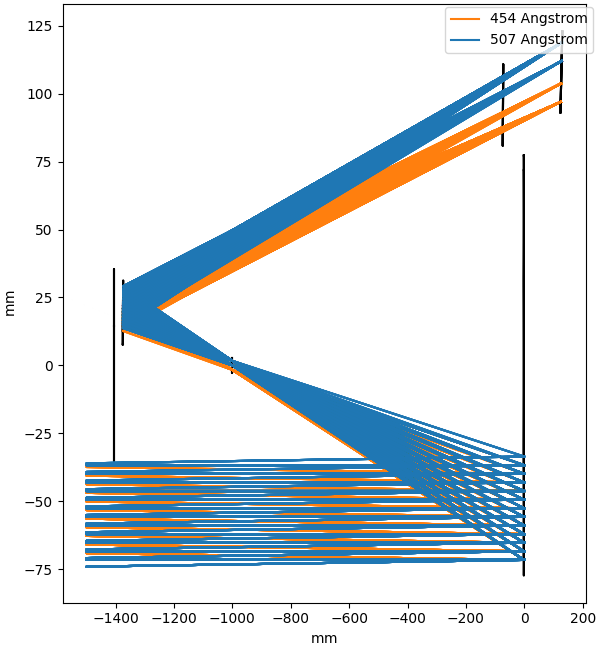

In [3]:
fig, ax = plt.subplots(
    figsize=(6, 6.5),
    constrained_layout=True
)
# ax.set_aspect("equal")
model.system.plot(
    components=('z','x'),
    color="black",
    kwargs_rays=dict(
        color=na.ScalarArray(np.array(["tab:orange", "tab:blue"]), axes="wavelength"),
        label=model.system.grid_input.wavelength.astype(int),
    ),
);
handles, labels = ax.get_legend_handles_labels()
labels = dict(zip(labels, handles))
fig.legend(labels.values(), labels.keys());

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=<matplotlib.collections.PathCollection object at 0x7f421522ab40>,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=<matplotlib.collections.PathCollection object at 0x7f4214a96390>,
        axes=(),
    ),
)

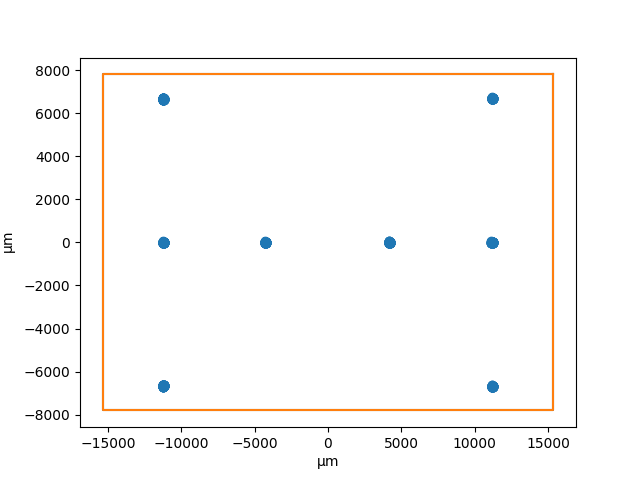

In [4]:
fig, ax = plt.subplots()

detector = model.system.surfaces_all[-1]
detector_plot = detector.plot(
    components=('x', 'y'),
    ax=ax,
    transformation=detector.transformation.inverse,
)

rays = model.system.rayfunction_default.outputs
rays = detector.transformation.inverse(rays)
na.plt.scatter(
    rays.position.x.to(u.um),
    rays.position.y.to(u.um),
    # c=na.linspace(-1, 1, 'slit', 3),
    where=rays.unvignetted,
    ax=ax,
)





In [5]:
x = rays.position.x
x = x - x.mean(axis=('pupil_x', 'pupil_y'))
y = rays.position.y
y = y - y.mean(axis=('pupil_x', 'pupil_y'))
rms_spot_size = np.sqrt(np.square(x) + np.square(y))
rms_spot_size.mean().to(u.um)


UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=40.07054548 um,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] um,
        axes=('_distribution',),
    ),
)

In [6]:
delta_z = model.field_stop.translation.z-model.grating.translation.z
delta_r = model.grating.distance_radial
theta = np.arctan2(delta_r,delta_z)
theta.to(u.deg)

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=3.16966731 deg,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] deg,
        axes=('_distribution',),
    ),
)

In [7]:
alpha = theta + model.grating.yaw
alpha.to(u.deg)

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=-0.48033269 deg,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] deg,
        axes=('_distribution',),
    ),
)

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=6.99349824 deg,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] deg,
        axes=('_distribution',),
    ),
)

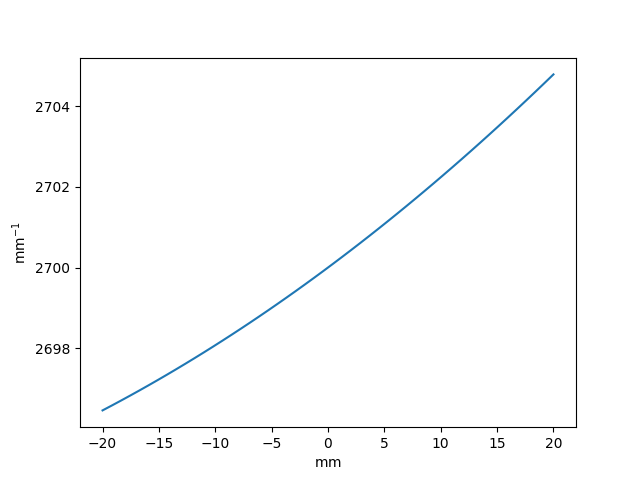

In [8]:
grating_r = na.linspace(-20 * u.mm, 20 * u.mm, 11)
line_spacing = 1/model.grating.rulings.spacing(
        position=na.Cartesian3dVectorArray(
            x = na.linspace(-20 * u.mm, 20 * u.mm, 11),
            y= 0 * u.mm,
            z = 0 * u.mm,
            )
    )

fig, ax =plt.subplots()
na.plt.plot(grating_r,line_spacing.x,ax=ax)

wavelength = na.ScalarArray([465, 499] * u.AA, axes='wavelength')

beta = np.arcsin(np.sin(alpha) + wavelength.mean()/model.grating.rulings.spacing(position=na.Cartesian3dVectorArray()*u.mm).length)
beta.to(u.deg)

In [9]:
image_z = model.detector.translation.z-model.grating.translation.z
image_r = model.detector.distance_radial - delta_r
beta = np.arctan2(image_r,image_z)-model.grating.yaw
beta.to(u.deg)

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=6.97527742 deg,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] deg,
        axes=('_distribution',),
    ),
)

In [10]:
object_distance = np.sqrt(
    np.square(model.grating.translation.z - model.field_stop.translation.z) + np.square(model.grating.distance_radial))
image_distance = np.sqrt(np.square(model.grating.translation.z - model.detector.translation.z) +
                         np.square(model.grating.distance_radial - model.detector.distance_radial)
                         )
magnification = image_distance / object_distance
magnification


UncertainScalarArray(
    nominal=4.00825573 ,
    distribution=ScalarArray(
        ndarray=[] ,
        axes=('_distribution',),
    ),
)

In [11]:
print(model.primary_mirror.translation.z)
print(model.field_stop.translation.z)
print(model.grating.translation.z)
print(model.detector.translation.z)

0.0 mm
-1000.0 mm
UniformUncertainScalarArray(
    nominal=-1374.7 mm,
    width=1.52752523e-05 m,
    num_distribution=0,
    seed=197795191413519682604790807733348064517,
)
126.96199885405804 mm


In [12]:
hole_spacing = 4 * 25.4 * u.mm
hole_spacing.to(u.mm)

<Quantity 101.6 mm>

In [13]:
new_primary_f = model.primary_mirror.sag.focal_length - hole_spacing * 6
new_primary_f


<Quantity -1609.6 mm>

In [14]:
new_fs_z = new_primary_f
new_fs_z

<Quantity -1609.6 mm>

In [15]:
extension_ratio = new_primary_f / model.primary_mirror.sag.focal_length
extension_ratio

<Quantity 1.6096>

In [16]:
old_grating_z = model.grating.translation.z - model.field_stop.translation.z
print(old_grating_z)
print(model.field_stop.translation.z)
print(model.grating.translation.z)
new_grating_z = old_grating_z * extension_ratio + new_fs_z
new_grating_z

UncertainScalarArray(
    nominal=-374.7 mm,
    distribution=ScalarArray(
        ndarray=[] mm,
        axes=('_distribution',),
    ),
)
-1000.0 mm
UniformUncertainScalarArray(
    nominal=-1374.7 mm,
    width=1.52752523e-05 m,
    num_distribution=0,
    seed=197795191413519682604790807733348064517,
)


UncertainScalarArray(
    nominal=-2212.71712 mm,
    distribution=ScalarArray(
        ndarray=[] mm,
        axes=('_distribution',),
    ),
)

In [17]:
model.primary_mirror.sag.focal_length = new_primary_f
model.field_stop.translation.z = new_fs_z
model.grating.translation.z = new_grating_z + 30 * u.mm

In [18]:
object_distance = np.sqrt(
    np.square(model.grating.translation.z - model.field_stop.translation.z) + np.square(model.grating.distance_radial))
image_distance = np.sqrt(np.square(model.grating.translation.z - model.detector.translation.z) +
                         np.square(model.grating.distance_radial - model.detector.distance_radial)
                         )
magnification = image_distance / object_distance
print(magnification)

print(object_distance)
print(image_distance)

UncertainScalarArray(
    nominal=4.03026366 ,
    distribution=ScalarArray(
        ndarray=[] ,
        axes=('_distribution',),
    ),
)
UncertainScalarArray(
    nominal=573.49262919 mm,
    distribution=ScalarArray(
        ndarray=[] mm,
        axes=('_distribution',),
    ),
)
UncertainScalarArray(
    nominal=2311.32650108 mm,
    distribution=ScalarArray(
        ndarray=[] mm,
        axes=('_distribution',),
    ),
)


In [19]:
new_grating_f = image_distance * object_distance / (image_distance + object_distance)
print(-2*new_grating_f)
print(model.grating.sag.radius)

UncertainScalarArray(
    nominal=-918.96833192 mm,
    distribution=ScalarArray(
        ndarray=[] mm,
        axes=('_distribution',),
    ),
)
UniformUncertainScalarArray(
    nominal=-597.83 mm,
    width=239.132 mm %,
    num_distribution=0,
    seed=162916202062846639206461928402328367883,
)


In [20]:
print(-2*new_grating_f/model.grating.sag.radius)

UncertainScalarArray(
    nominal=1.53717333 ,
    distribution=ScalarArray(
        ndarray=[] ,
        axes=('_distribution',),
    ),
)


In [21]:
model.grating.sag.radius = -2 * new_grating_f.nominal * 0.9975

model.grating.yaw = -2.51 * u.deg

c0 = 1 / (1850 / u.mm)
c1 = -2.852e-5 * (u.um / u.mm)
c2 = -2.112e-7 * (u.um / u.mm ** 2)

model.grating.rulings.spacing.coefficients[0].nominal = c0
model.grating.rulings.spacing.coefficients[1].nominal = c1
model.grating.rulings.spacing.coefficients[2].nominal = c2

In [22]:
# print(model.primary_mirror.translation.z)
# print(model.field_stop.transformation)
# print(model.grating.translation.z)
# print(model.detector.translation.z)

model.central_obscuration.translation.z = model.grating.translation.z - 25 * u.mm
model.front_aperture.translation.z = model.grating.translation.z - 100 * u.mm

In [23]:
model.filter.radius_clear = 40 * u.mm

In [24]:
model.detector.yaw

<Quantity -12.252 deg>

In [25]:
del model.system

wavelength = na.ScalarArray([465, 499] * u.AA, axes='wavelength')
# model.grating.sag.radius = - 9.17468102e+02 * u.mm
# rays = model.system.raytrace(wavelength=wavelength)
# rays.outputs.shape

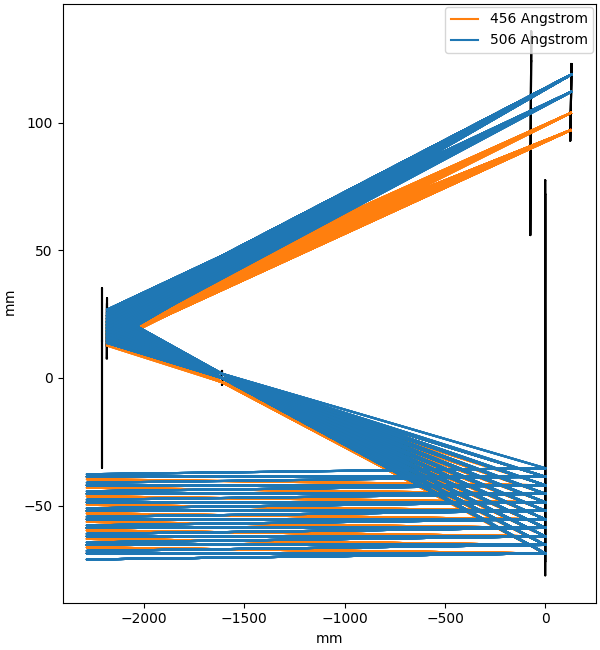

In [26]:
fig, ax = plt.subplots(
    figsize=(6, 6.5),
    constrained_layout=True
)
# ax.set_aspect("equal")
model.system.plot(
    components=("z", "x"),
    color="black",
    kwargs_rays=dict(
        color=na.ScalarArray(np.array(["tab:orange", "tab:blue"]), axes="wavelength"),
        label=model.system.grid_input.wavelength.astype(int),
    ),
    # plot_rays_vignetted=True,
    # wavelength=wavelength,
)
handles, labels = ax.get_legend_handles_labels()
labels = dict(zip(labels, handles))
fig.legend(labels.values(), labels.keys());

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=<matplotlib.collections.PathCollection object at 0x7f420ef9ac00>,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=<matplotlib.collections.PathCollection object at 0x7f420efb4590>,
        axes=(),
    ),
)

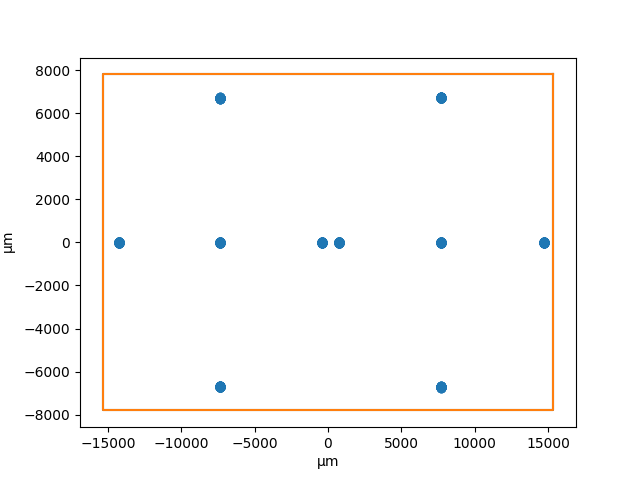

In [27]:
fig, ax = plt.subplots()

detector = model.system.surfaces_all[-1]
detector_plot = detector.plot(
    components=('x', 'y'),
    ax=ax,
    transformation=detector.transformation.inverse,
    # transformation=None,
)

rays = model.system.raytrace(wavelength=wavelength).outputs[dict(surface=-1)]

rays = detector.transformation.inverse(rays)
na.plt.scatter(
    rays.position.x,
    rays.position.y,
    where=rays.unvignetted,
)


In [28]:
x = rays.position.x
x = x - x.mean(axis=('pupil_x', 'pupil_y'))
y = rays.position.y
y = y - y.mean(axis=('pupil_x', 'pupil_y'))
rms_spot_size = np.sqrt(np.square(x) + np.square(y))
rms_spot_size.mean().to(u.um)

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=21.64597711 um,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] um,
        axes=('_distribution',),
    ),
)

In [29]:
np.abs(rays.position[dict(wavelength=0)].x.mean()) - 8 * u.mm

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=-0.66742346 mm,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] mm,
        axes=('_distribution',),
    ),
)

In [30]:
np.abs(rays.position[dict(wavelength=1)].x.mean()) - 8 * u.mm

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=-0.27082712 mm,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] mm,
        axes=('_distribution',),
    ),
)

In [31]:
def esis_ii_merit(
        guesses,
        model=None,
        # wavelength = None, 
        weight=None,
        # units = None
):
    # guess = [guess*unit for guess,unit in zip(guesses,units)]
    # print(guesses)
    # grating_yaw, grating_c0, grating_c1, grating_c2, grating_roc, detector_yaw = guesses
    grating_yaw, grating_c0, grating_c1, grating_c2, grating_roc = guesses


    model.grating.yaw = grating_yaw * u.deg
    model.grating.rulings.spacing.coefficients[0] = grating_c0 * u.mm
    model.grating.rulings.spacing.coefficients[1] = grating_c1 * u.um / u.mm
    model.grating.rulings.spacing.coefficients[2] = grating_c2 * u.um / u.mm ** 2
    model.grating.sag.radius = grating_roc * u.mm
    # model.detector.yaw = detector_yaw * u.deg

    wavelength = na.ScalarArray([465, 499] * u.AA, axes='wavelength')

    del model.system
    rays = model.system.raytrace(wavelength=wavelength).outputs[dict(surface=-1)]
    detector = model.system.surfaces_all[-1]

    rays = detector.transformation.inverse(rays)

    x = rays.position.x
    x = x - x.mean(axis=('pupil_x', 'pupil_y'))
    y = rays.position.y
    y = y - y.mean(axis=('pupil_x', 'pupil_y'))

    r_squared = np.square(x) + np.square(y)
    rms_spot_size = np.sqrt(r_squared)

    t1 = np.abs(rays.position[dict(wavelength=0)].x.mean()) - 7.35 * u.mm
    t2 = np.abs(rays.position[dict(wavelength=-1)].x.mean()) - 7.35 * u.mm

    t = rms_spot_size.mean().nominal
    merit = t + weight * np.sqrt(np.square(t1.nominal) + np.square(t2.nominal))

    # print(t.value, t1.nominal.value, t2.nominal.value)
    print(merit.ndarray.value)
    return merit.ndarray.value





In [32]:
model.grating.sag.radius

<Quantity -916.67091109 mm>

In [33]:
from scipy.optimize import minimize, differential_evolution

guess = [
    model.grating.yaw,
    model.grating.rulings.spacing.coefficients[0].nominal,
    model.grating.rulings.spacing.coefficients[1].nominal,
    model.grating.rulings.spacing.coefficients[2].nominal,
    model.grating.sag.radius,
    # model.detector.yaw
]
guess_units = [g.unit for g in guess]
print(guess_units)

guess_values = [g.value for g in guess]
# guess_values = [-2.47016209e+00, 5.49599486e-04, -1.80866504e-05, -1.08341748e-07,
#                 -9.17468102e+02, -1.04771264e+01]
# guess_values = [-2.47016209e+00, 5.49599486e-04, -1.80866504e-05, -1.08341748e-07,
                # -9.17468102e+02]

print(guess_values)


[Unit("deg"), Unit("mm"), Unit("um / mm"), Unit("um / mm2"), Unit("mm")]
[-2.51, 0.0005405405405405405, -2.852e-05, -2.112e-07, -916.6709110934604]


In [34]:
esis_ii_merit(guess_values, model=model, weight=1)

# bounds = [(-2.6, -2.45), (1 / 1900, 1 / 1800), (-3e-5, -1e-5), (-2.15e-7, -1e-7), (917, 921), (-15, -10)]
# bounds = [(-2.54, -2.48), (1 / 1860, 1 / 1840), (-2.9e-5, -2.7e-5), (-2.15e-7, -2e-7), (-917, -915)]
bounds = [(-2.6, -2.45), (1 / 1900, 1 / 1800), (-3e-5, -1e-5), (-2.15e-7, -1e-7), (-918, -914)]



# fit = minimize(esis_ii_merit, guess_values, (model, 1),
#                bounds=bounds,
#                )
# w = 15
# fit = differential_evolution(esis_ii_merit,x0=guess_values,args = (model,1),bounds=bounds,
#                              workers=w,
#                              polish=False,
#                             )

0.40121895715419315


In [35]:
# print(fit.x)

In [37]:
guess = [-2.45125246e+00,  5.53764773e-04, -1.83548407e-05, -1.17579027e-07,
 -9.17485462e+02]

In [38]:
# guess = [-2.53962948e+00, 5.34862656e-04, -2.10590822e-05, -1.94958850e-07,
#          9.18952281e+02, -1.22332163e+01]

# guess = [-2.47016209e+00, 5.49599486e-04, -1.80866504e-05, -1.08341748e-07,
#          9.17468102e+02, -1.04771264e+01]

# guess = [-2.50429148e+00,  5.41200713e-04 ,-2.77220822e-05 ,-2.02847671e-07,
#  -9.16287793e+02]
# # guess = [-2.53962948e+00,  0, 0, 0,
# #   9.1895221e+02, 0]

# grating_yaw, grating_c0, grating_c1, grating_c2, grating_roc = fit.x
grating_yaw, grating_c0, grating_c1, grating_c2, grating_roc = guess

model.grating.yaw = grating_yaw * u.deg
model.grating.rulings.spacing.coefficients[0] = grating_c0 * u.mm
model.grating.rulings.spacing.coefficients[1] = grating_c1 * u.um / u.mm
model.grating.rulings.spacing.coefficients[2] = grating_c2 * u.um / u.mm ** 2
model.grating.sag.radius = grating_roc * u.mm


In [39]:
# model.grating.distance_radial = 21 * u.mm

In [40]:
del model.system
model.system.raytrace(wavelength=wavelength)

RayFunctionArray(
    inputs=ObjectVectorArray(
        wavelength=ScalarArray(
            ndarray=[465., 499.] Angstrom,
            axes=('wavelength',),
        ),
        field=Cartesian2dVectorArray(
            x=UncertainScalarArray(
                nominal=ScalarArray(
                    ndarray=[-1.03314768e-03, -2.03723392e-07,  1.03274023e-03] ,
                    axes=('field_x',),
                ),
                distribution=ScalarArray(
                    ndarray=[] ,
                    axes=('_distribution', 'field_x'),
                ),
            ),
            y=UncertainScalarArray(
                nominal=ScalarArray(
                    ndarray=[-1.03368611e-03,  2.82674149e-09,  1.03369176e-03] ,
                    axes=('field_y',),
                ),
                distribution=ScalarArray(
                    ndarray=[] ,
                    axes=('_distribution', 'field_y'),
                ),
            ),
        ),
        pupil=Cartesian2dVect

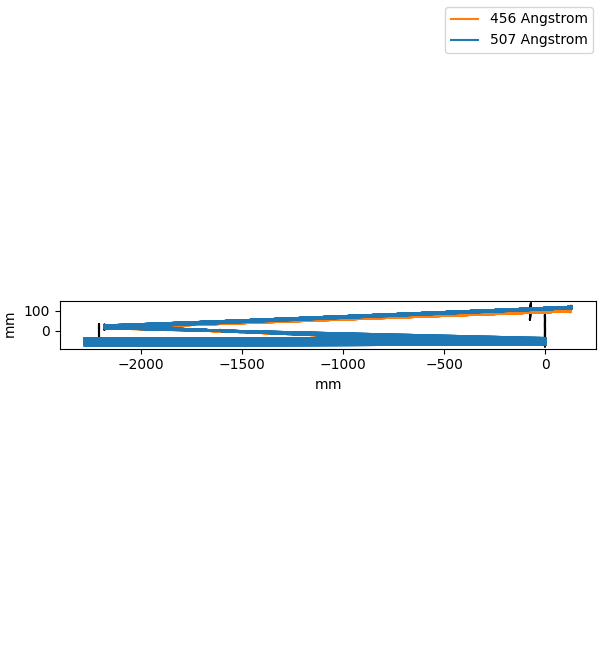

In [41]:
fig, ax = plt.subplots(
    figsize=(6, 6.5),
    constrained_layout=True
)
ax.set_aspect("equal")
model.system.plot(
    components=("z", "x"),
    color="black",
    kwargs_rays=dict(
        color=na.ScalarArray(np.array(["tab:orange", "tab:blue"]), axes="wavelength"),
        label=model.system.grid_input.wavelength.astype(int),
    ),
    plot_rays_vignetted=False,
    # wavelength=wavelength,
)
handles, labels = ax.get_legend_handles_labels()
labels = dict(zip(labels, handles))
fig.legend(labels.values(), labels.keys());

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=<matplotlib.collections.PathCollection object at 0x7f4214158470>,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=<matplotlib.collections.PathCollection object at 0x7f420e801a90>,
        axes=(),
    ),
)

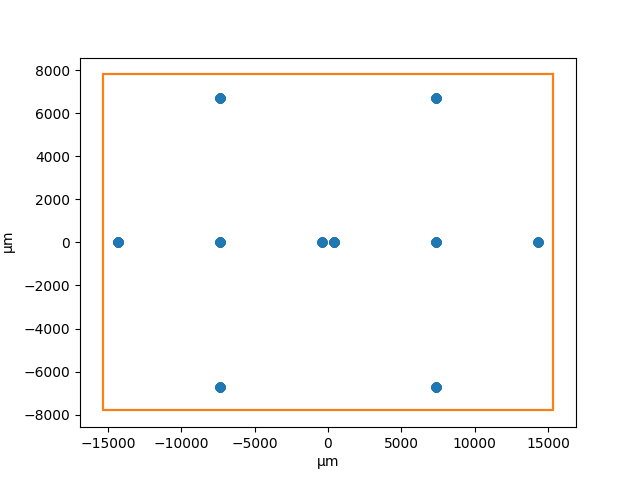

In [42]:
fig, ax = plt.subplots()

detector = model.system.surfaces_all[-1]
detector_plot = detector.plot(
    components=('x', 'y'),
    ax=ax,
    transformation=detector.transformation.inverse,
    # transformation=None,
)
del model.system
rays = model.system.raytrace(wavelength=wavelength).outputs[dict(surface=-1)]

rays = detector.transformation.inverse(rays)
na.plt.scatter(
    rays.position.x,
    rays.position.y,
    where=rays.unvignetted,
)

In [43]:
x = rays.position.x
x = x - x.mean(axis=('pupil_x', 'pupil_y'))
y = rays.position.y
y = y - y.mean(axis=('pupil_x', 'pupil_y'))
rms_spot_size = np.sqrt(np.square(x) + np.square(y))
rms_spot_size.mean(axis=('pupil_x','pupil_y')).to(u.um)

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=[[[1.7776845 , 1.47949965, 1.77768753],
                  [2.77630905, 2.54040493, 2.77631155],
                  [4.78377054, 4.67017094, 4.78377181]],

                 [[4.15284429, 4.15248434, 4.1528443 ],
                  [2.35574385, 2.28227889, 2.35574471],
                  [2.01860199, 1.76565798, 2.01860474]]] um,
        axes=('wavelength', 'field_x', 'field_y'),
    ),
    distribution=ScalarArray(
        ndarray=[] um,
        axes=('wavelength', 'field_x', 'field_y', '_distribution'),
    ),
)

In [44]:
np.abs(rays.position[dict(wavelength=0)].x.mean()) - 8 * u.mm

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=-0.65000186 mm,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] mm,
        axes=('_distribution',),
    ),
)

In [45]:
np.abs(rays.position[dict(wavelength=1)].x.mean()) - 8 * u.mm

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=-0.65001375 mm,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] mm,
        axes=('_distribution',),
    ),
)

In [46]:
model.grating.translation

Cartesian3dVectorArray(
    x=UniformUncertainScalarArray(
        nominal=0. mm,
        width=1. mm,
        num_distribution=0,
        seed=318677164971787728874598801493942858040,
    ),
    y=UniformUncertainScalarArray(
        nominal=0. mm,
        width=1. mm,
        num_distribution=0,
        seed=114545728427501606795188272364391466906,
    ),
    z=UncertainScalarArray(
        nominal=-2182.71712 mm,
        distribution=ScalarArray(
            ndarray=[] mm,
            axes=('_distribution',),
        ),
    ),
)

In [47]:
model.grating.distance_radial

<Quantity 20.74999998 mm>

In [48]:
model.grating.yaw

<Quantity -2.45125246 deg>

In [49]:
model.field_stop.translation

Cartesian3dVectorArray(
    x=UniformUncertainScalarArray(
        nominal=0. mm,
        width=1. mm,
        num_distribution=0,
        seed=234974178102692769606561751630588215521,
    ),
    y=UniformUncertainScalarArray(
        nominal=0. mm,
        width=1. mm,
        num_distribution=0,
        seed=96954259914765292992090252814518312038,
    ),
    z=-1609.6 mm,
)

In [56]:
delta_z = model.field_stop.translation.z-model.grating.translation.z
delta_r = model.grating.distance_radial
theta = np.arctan2(delta_r,delta_z)
theta.to(u.deg)

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=2.07351746 deg,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] deg,
        axes=('_distribution',),
    ),
)

In [57]:
alpha = theta + model.grating.yaw
alpha.to(u.deg)

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=-0.377735 deg,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] deg,
        axes=('_distribution',),
    ),
)

ScalarArray(
    ndarray=[465., 499.] Angstrom,
    axes=('wavelength',),
)

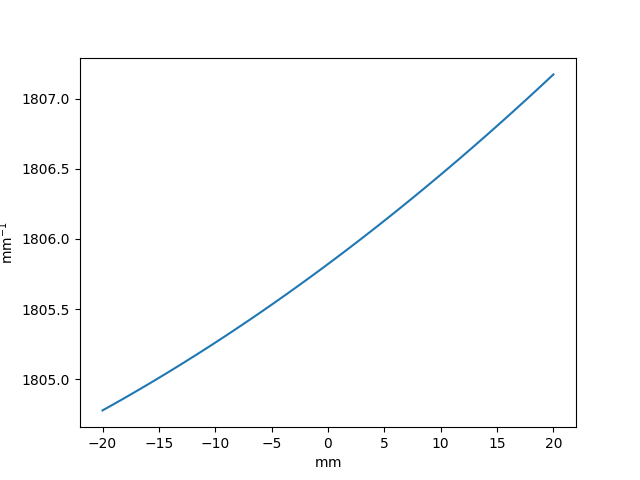

In [ ]:
grating_r = na.linspace(-20 * u.mm, 20 * u.mm, 11)
line_spacing = 1/model.grating.rulings.spacing(
        position=na.Cartesian3dVectorArray(
            x = na.linspace(-20 * u.mm, 20 * u.mm, 11),
            y= 0 * u.mm,
            z = 0 * u.mm,
            )
    )

fig, ax =plt.subplots()
na.plt.plot(grating_r,line_spacing.x,ax=ax)

wavelength

In [53]:
beta = np.arcsin(np.sin(alpha) + wavelength.mean()/model.grating.rulings.spacing(position=na.Cartesian3dVectorArray()*u.mm).length)
beta.to(u.deg)

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=4.61431124 deg,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] deg,
        axes=('_distribution',),
    ),
)

In [54]:
image_z = model.detector.translation.z-model.grating.translation.z
image_r = model.detector.distance_radial - delta_r
beta = np.arctan2(image_r,image_z)-model.grating.yaw
beta.to(u.deg)

UncertainScalarArray(
    nominal=ScalarArray(
        ndarray=4.61461829 deg,
        axes=(),
    ),
    distribution=ScalarArray(
        ndarray=[] deg,
        axes=('_distribution',),
    ),
)